In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np 
import random
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
from skimage.io import imread
import matplotlib.pyplot as plt

In [2]:
vid = imread('eyeTrackingCleanExample.mp4')
print(vid.shape)

(504, 1024, 1280, 3)


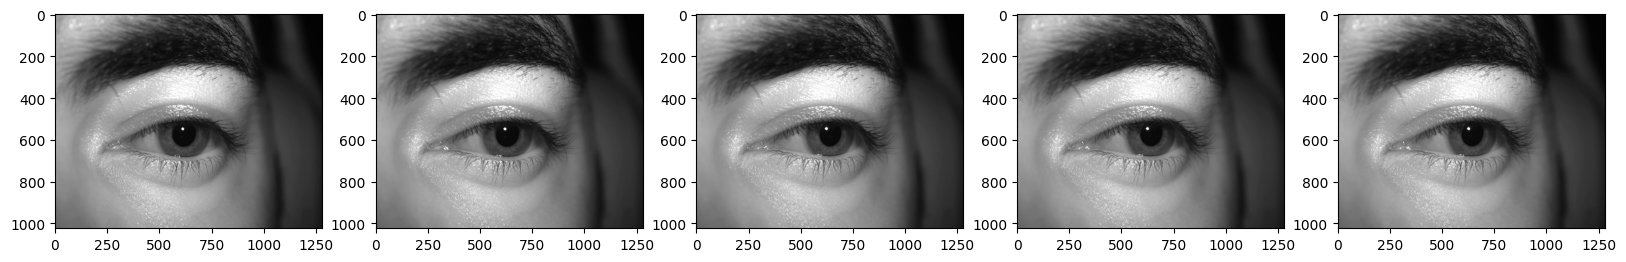

In [3]:
fig,ax = plt.subplots(1,5,figsize=(20,5))
for i in range(5):
    ax[i].imshow(vid[i])
plt.show()

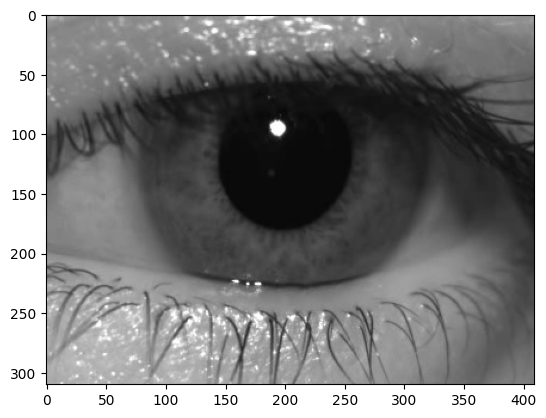

In [7]:
#box coords = array([416, 454, 409, 310])
first_frame = vid[0]
widget = [{'x': 416, 'y': 454, 'width': 409, 'height': 310, 'label': ''}]
bbox = widget[0]
bbox = np.array((bbox['x'], bbox['y'], bbox['width'], bbox['height']))
cropped_frame = first_frame[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]]
plt.imshow(cropped_frame)

(-0.5, 408.5, 309.5, -0.5)

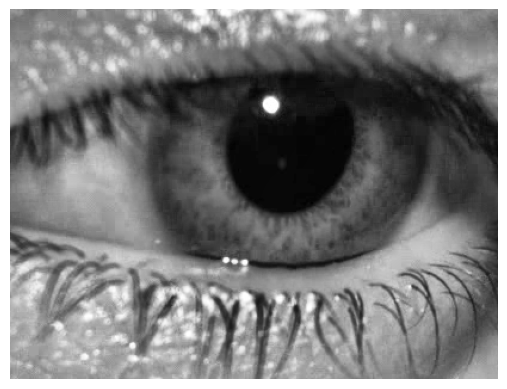

In [117]:
from skimage import exposure
frame_cont = exposure.equalize_adapthist(cropped_frame)
plt.imshow(frame_cont)
plt.axis('off')

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

c:\Users\BiswanathSaha\miniconda3\envs\stable\lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [9]:
from PIL import Image 
img = Image.fromarray(cropped_frame)

In [12]:
prompts  = ['black circle']
inputs = processor(text=prompts,images=[img]*len(prompts),padding='max_length',return_tensors='pt')
#predict
with torch.no_grad():
    outputs = model(**inputs)
preds = nn.functional.interpolate(outputs.logits.unsqueeze(1),size=(img.size[1],img.size[0]),mode='bilinear')

Unused or unrecognized kwargs: padding.


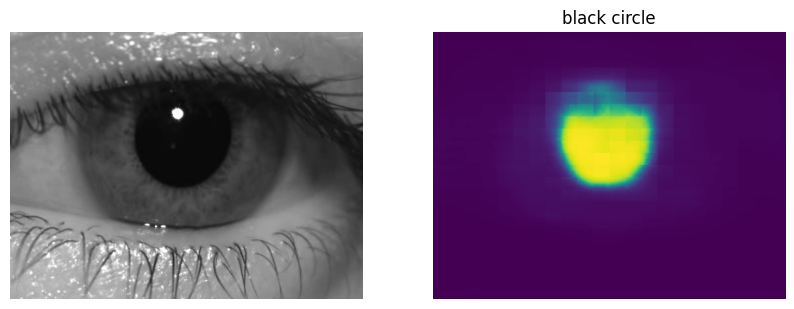

In [13]:
#plot
fig,ax = plt.subplots(1,len(prompts)+1,figsize=(10,7))
ax[0].imshow(img)
ax[0].axis('off')
for i in range(len(prompts)):
    ax[i+1].imshow(torch.sigmoid(preds[i][0]))
    ax[i+1].set_title(prompts[i])
    ax[i+1].axis('off')
plt.show()

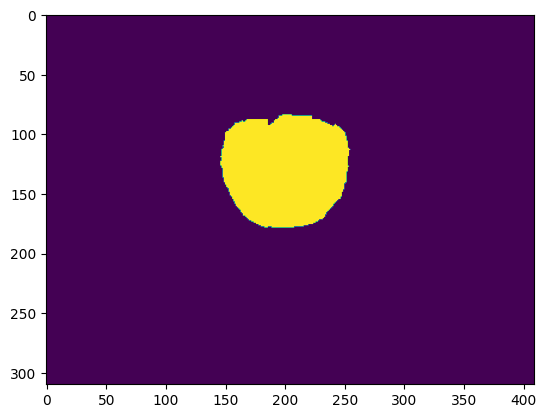

In [60]:
threshold = 0.5
pred = torch.sigmoid(preds[0][0])
pred = (pred > threshold).float()
plt.imshow(pred)

In [16]:
import random 

In [51]:
def sample_points_based_on_preds(preds, N):
    height, width = preds.shape
    weights = preds.ravel()
    indices = np.arange(height * width)

    # Randomly sample N indices based on the weights
    sampled_indices = random.choices(indices, weights=weights, k=N)

    # Convert the sampled indices into (col, row) coordinates
    sampled_points = [(index % width, index // width) for index in sampled_indices]

    return sampled_points

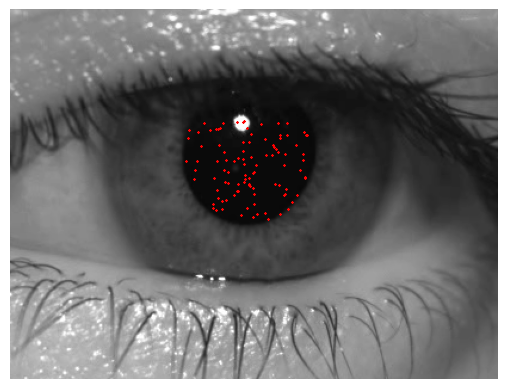

In [61]:
#sample points
sampled_points = sample_points_based_on_preds(pred, 100)

#plot
_,ax = plt.subplots()
ax.imshow(img)
x,y = zip(*sampled_points)
ax.scatter(x,y,s=1,c='r',marker='x')
ax.axis('off')
plt.show()

In [62]:
def upsample_pred(pred, image_source):
    pred = pred.unsqueeze(dim=0)
    original_height = image_source.shape[0]
    original_width = image_source.shape[1]

    larger_dim = max(original_height, original_width)
    aspect_ratio = original_height / original_width

    # upsample the tensor to the larger dimension
    upsampled_tensor = F.interpolate(
        pred, size=(larger_dim, larger_dim), mode="bilinear", align_corners=False
    )

    # remove the padding (at the end) to get the original image resolution
    if original_height > original_width:
        target_width = int(upsampled_tensor.shape[3] * aspect_ratio)
        upsampled_tensor = upsampled_tensor[:, :, :, :target_width]
    else:
        target_height = int(upsampled_tensor.shape[2] * aspect_ratio)
        upsampled_tensor = upsampled_tensor[:, :, :target_height, :]
    return upsampled_tensor.squeeze(dim=1)

In [63]:
def sam_mask_from_points(predictor, image_array, points):
    predictor.set_image(image_array)
    points_array = np.array(points)
    # we only sample positive points, so labels are all 1
    points_labels = np.ones(len(points))
    # we don't use predict_torch here cause it didn't seem to work...
    masks, scores, logits = predictor.predict(
        point_coords=points_array,
        point_labels=points_labels,
    )
    # max over the 3 segmentation levels
    total_pred = torch.max(torch.sigmoid(torch.tensor(logits)), dim=0)[0].unsqueeze(
        dim=0
    )
    # logits are 256x256 -> upsample back to image shape
    upsampled_pred = upsample_pred(total_pred, image_array)
    return upsampled_pred

In [34]:
from segment_anything import*

In [35]:
checkpoint = 'D://portfolio//sam_vit_h_4b8939.pth'
model_type = 'vit_h'
sam = sam_model_registry[model_type](checkpoint=checkpoint)
sam.to('cuda')
predictor = SamPredictor(sam)

In [64]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2)) 

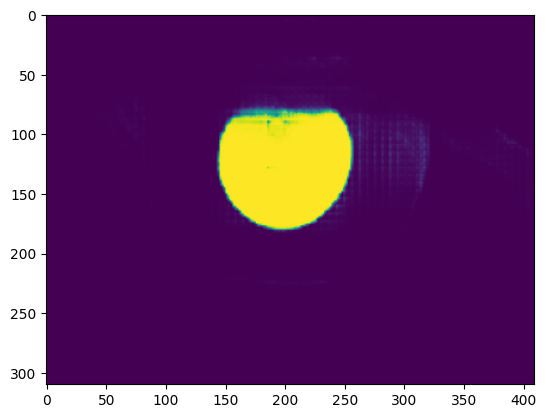

In [65]:
pred_mask = sam_mask_from_points(predictor, np.array(img), sampled_points)
plt.imshow(pred_mask.squeeze(0))

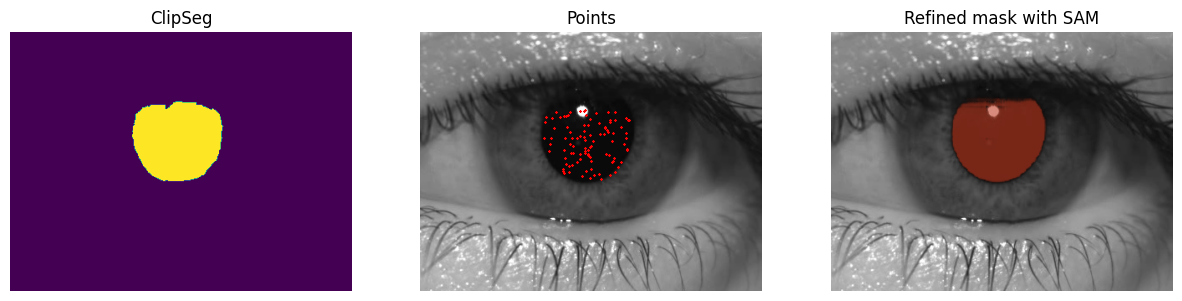

In [66]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
#clipseg
ax[0].imshow(pred)
ax[0].set_title('ClipSeg')
ax[0].axis('off')
#points
ax[1].imshow(img)
x,y = zip(*sampled_points)
ax[1].scatter(x,y,s=1,c='r',marker='x')
ax[1].set_title('Points')
ax[1].axis('off')
#sam
ax[2].imshow(img)
show_mask(pred_mask, ax[2], random_color=True)
ax[2].set_title('Refined mask with SAM')
ax[2].axis('off')
plt.show();

In [67]:
#crop all frames
cropped_frames = []
for frame in vid:
    cropped_frame = frame[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]]
    cropped_frames.append(cropped_frame)

cropped_frames = np.array(cropped_frames)
print(cropped_frames.shape)

(504, 310, 409, 3)


In [69]:
#run it for all frames
from tqdm.notebook import tqdm
pupil_masks = []
for frame in tqdm(cropped_frames):
    img = Image.fromarray(frame)
    inputs = processor(text=prompts,images=[img]*len(prompts),padding='max_length',return_tensors='pt')
    with torch.no_grad():
        outputs = model(**inputs)
    preds = nn.functional.interpolate(outputs.logits.unsqueeze(1),size=(img.size[1],img.size[0]),mode='bilinear')
    pred = torch.sigmoid(preds[0][0])
    pred = (pred > threshold).float()
    sampled_points = sample_points_based_on_preds(pred, 100)
    pred_mask = sam_mask_from_points(predictor, np.array(img), sampled_points)
    pupil_masks.append(pred_mask.squeeze(0))


  0%|          | 0/504 [00:00<?, ?it/s]

Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


In [70]:
pupil_masks = np.array(pupil_masks)

In [71]:
print(pupil_masks.shape)

(504, 310, 409)


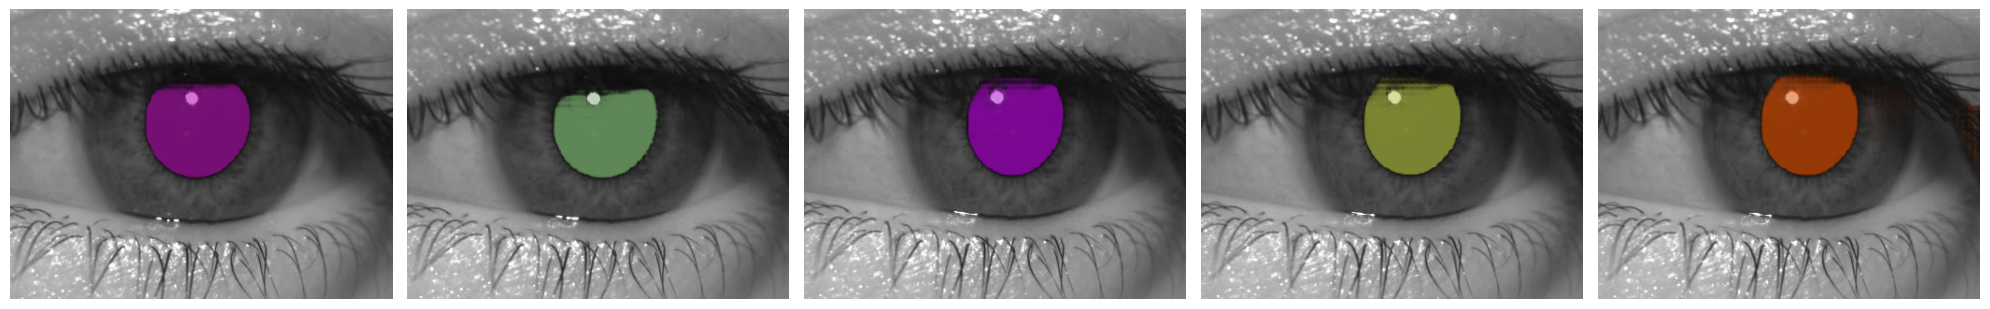

In [72]:
fig,ax = plt.subplots(1,5,figsize=(20,5))
for i in range(5):
    ax[i].imshow(cropped_frames[i])
    show_mask(pupil_masks[i], ax[i], random_color=True)
    ax[i].axis('off')
plt.tight_layout()
plt.show();

In [78]:
#calculate center of mass
from scipy.ndimage import center_of_mass
centers = []
for mask in pupil_masks:
    center = center_of_mass(mask)
    centers.append(center)

centers = np.array(centers)

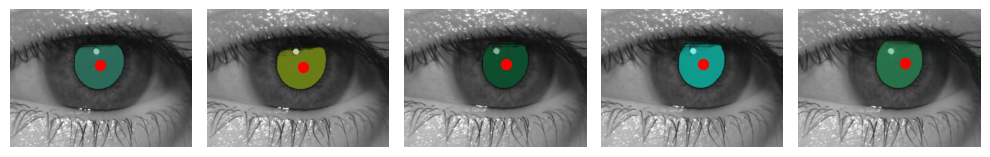

In [81]:
fig,ax = plt.subplots(1,5,figsize=(10,5))
for i in range(5):
    ax[i].imshow(cropped_frames[i])
    show_mask(pupil_masks[i], ax[i], random_color=True)
    ax[i].scatter(centers[i][1], centers[i][0], c='r', s=50)
    ax[i].axis('off')
plt.tight_layout()
plt.show();

In [83]:
from scipy.spatial import distance
distance = np.linalg.norm(np.diff(centers, axis=0), axis=1)
cumulative_distance = np.cumsum(distance)

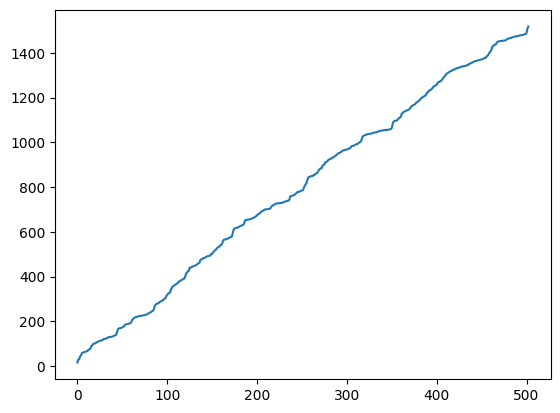

In [84]:
plt.plot(cumulative_distance)

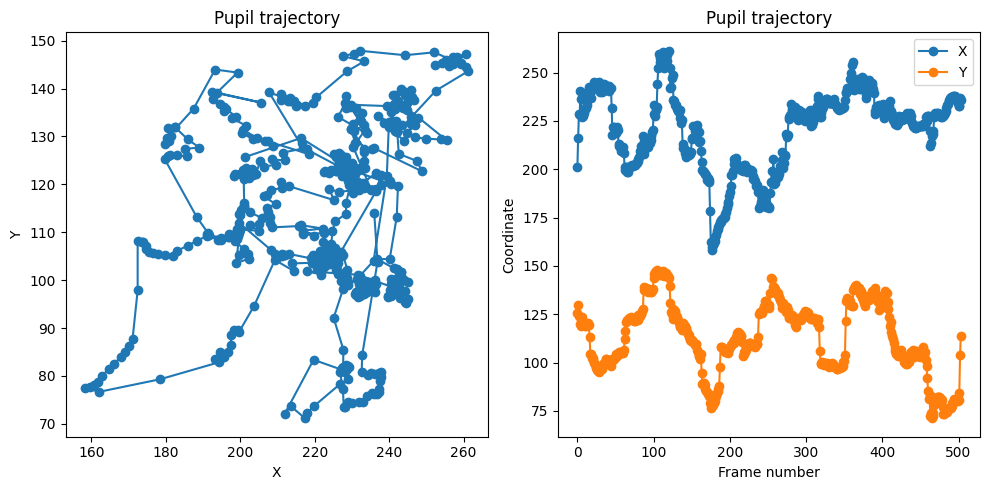

In [85]:
#trajectory
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(centers[:, 1], centers[:, 0], marker='o')
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
ax[0].set_title('Pupil trajectory')
ax[1].plot(centers[:, 1], marker='o', label='X')
ax[1].plot(centers[:, 0], marker='o', label='Y')
ax[1].set_xlabel('Frame number')
ax[1].set_ylabel('Coordinate')
ax[1].set_title('Pupil trajectory')
ax[1].legend()
plt.tight_layout()
plt.show();

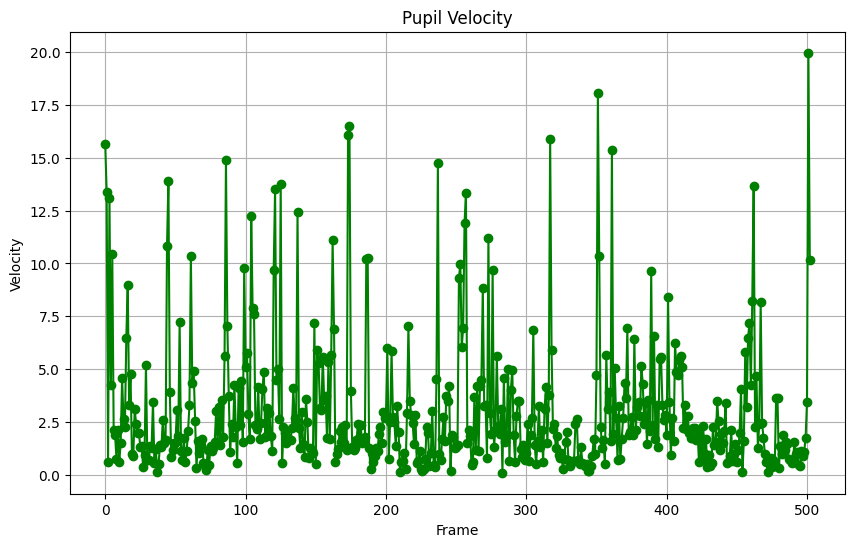

In [86]:
#velocity 
velocity  = distance / np.diff(range(len(centers)))
plt.figure(figsize=(10, 6))
plt.plot(velocity, marker='o', linestyle='-', color='g')
plt.title('Pupil Velocity')
plt.xlabel('Frame')
plt.ylabel('Velocity')
plt.grid(True)
plt.show()

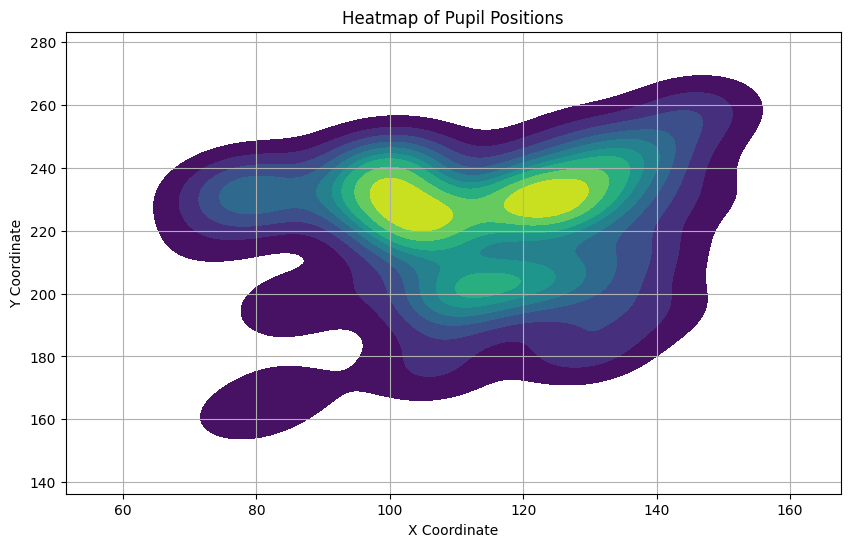

In [87]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.kdeplot(x=centers[:, 0], y=centers[:, 1], fill=True, cmap="viridis")
plt.title('Heatmap of Pupil Positions')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.show()

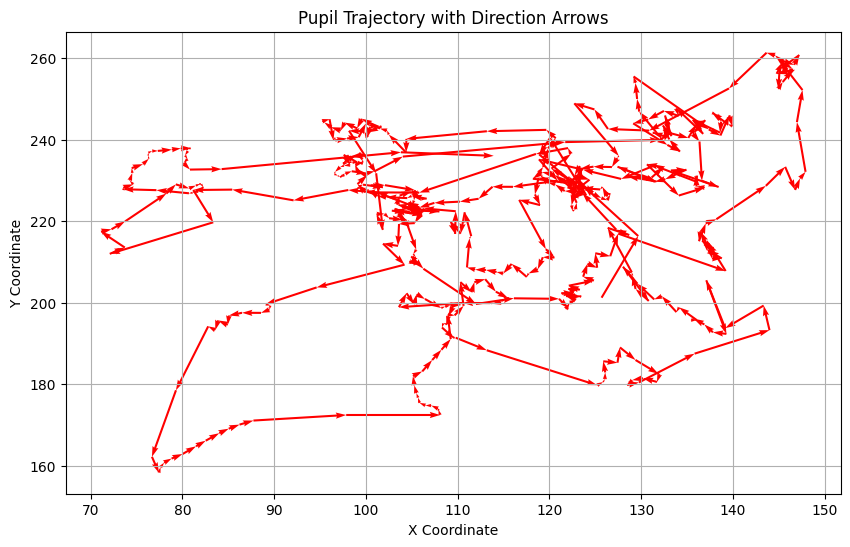

In [94]:
X = centers[:, 0]
Y = centers[:, 1]

# Calculate differences
dX = np.diff(X)
dY = np.diff(Y)

# Plotting the trajectory with direction arrows
plt.figure(figsize=(10, 6))
#plt.plot(X, Y, linestyle='--', color='b')
plt.quiver(X[:-1], Y[:-1], dX, dY, angles='xy', scale_units='xy', scale=1, color='r')
plt.title('Pupil Trajectory with Direction Arrows')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.show()

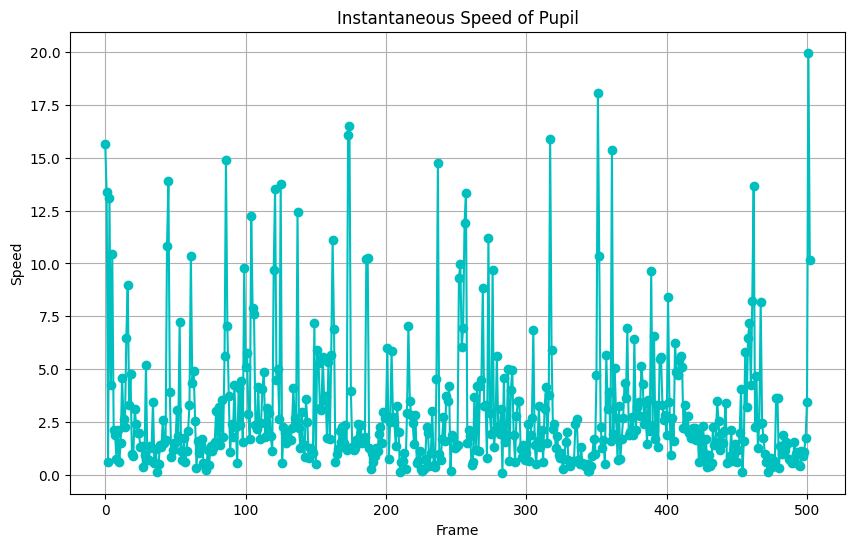

In [95]:
# Assuming a constant frame interval, e.g., 1 unit time
frame_interval = 1

# Calculate instantaneous speed
speed = distance / frame_interval

# Plotting the instantaneous speed
plt.figure(figsize=(10, 6))
plt.plot(speed, marker='o', linestyle='-', color='c')
plt.title('Instantaneous Speed of Pupil')
plt.xlabel('Frame')
plt.ylabel('Speed')
plt.grid(True)
plt.show();

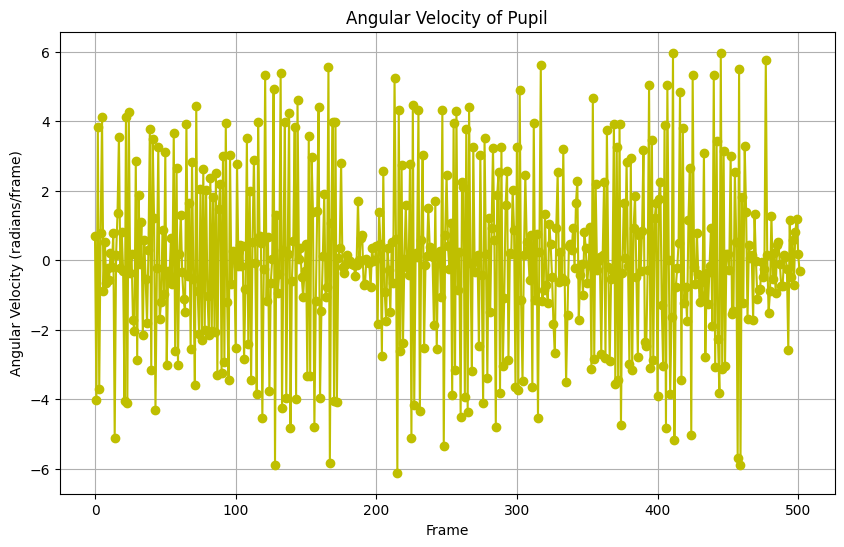

In [97]:
directions = np.arctan2(dY, dX)

# Calculate angular velocity (change in direction)
angular_velocity = np.diff(directions) / frame_interval

# Plotting the angular velocity
plt.figure(figsize=(10, 6))
plt.plot(angular_velocity, marker='o', linestyle='-', color='y')
plt.title('Angular Velocity of Pupil')
plt.xlabel('Frame')
plt.ylabel('Angular Velocity (radians/frame)')
plt.grid(True)
plt.show()

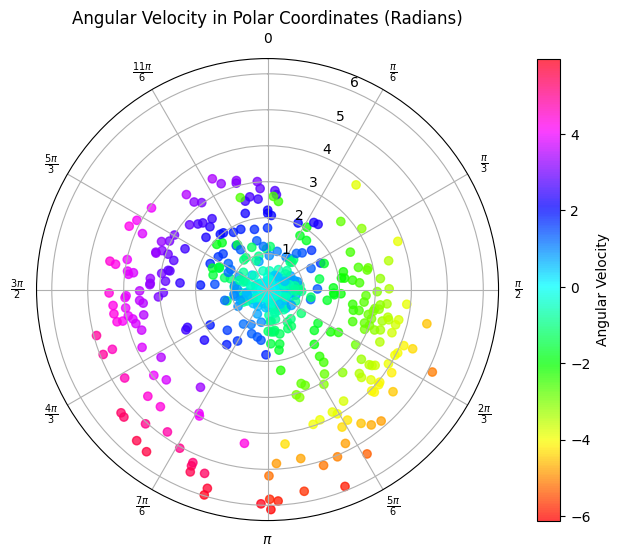

In [105]:
# Extracting X and Y coordinates
X = centers[:, 0]
Y = centers[:, 1]

# Calculate differences
dX = np.diff(X)
dY = np.diff(Y)

# Calculate direction vectors (angles in radians)
directions = np.arctan2(dY, dX)

# Calculate angular velocity (change in direction)
angular_velocity = np.diff(directions)

# Prepare the angles for polar plot (excluding the last point due to diff)
angles = directions[:-1]

# Setup polar plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, polar=True)

# Plotting the angular velocity on the polar plot
c = ax.scatter(angles, np.abs(angular_velocity), c=angular_velocity, cmap='hsv', alpha=0.75)
fig.colorbar(c, label='Angular Velocity')

# Adding title and labels
ax.set_title('Angular Velocity in Polar Coordinates (Radians)')
ax.set_theta_zero_location('N')  # Set 0 degrees to the top (North)
ax.set_theta_direction(-1)  # Clockwise

# Customizing tick labels to show radians
radian_ticks = [0, np.pi/6, np.pi/3, np.pi/2, 2*np.pi/3, 5*np.pi/6, np.pi, 7*np.pi/6, 4*np.pi/3, 3*np.pi/2, 5*np.pi/3, 11*np.pi/6]
radian_labels = ['0', r'$\frac{\pi}{6}$', r'$\frac{\pi}{3}$', r'$\frac{\pi}{2}$', r'$\frac{2\pi}{3}$', r'$\frac{5\pi}{6}$', r'$\pi$', r'$\frac{7\pi}{6}$', r'$\frac{4\pi}{3}$', r'$\frac{3\pi}{2}$', r'$\frac{5\pi}{3}$', r'$\frac{11\pi}{6}$']
ax.set_xticks(radian_ticks)
ax.set_xticklabels(radian_labels)

# Display the plot
plt.show();

In [110]:
#calculate dice scores
from scipy.spatial.distance import dice
dice_scores = []
for i in range(len(pupil_masks)):
    dice_score = dice(pupil_masks[i].ravel(), k_means_mask[i].ravel())
    dice_scores.append(dice_score)

dice_scores = np.array(dice_scores)

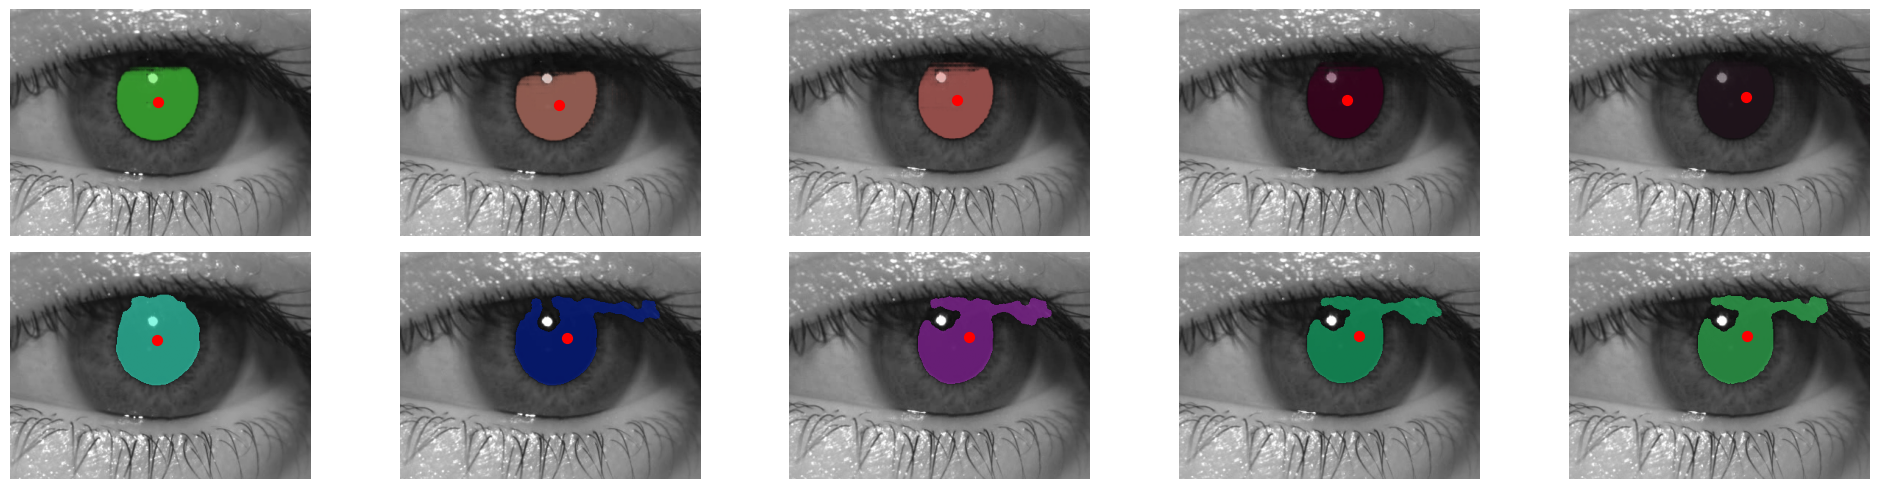

In [114]:
#plot
fig,ax = plt.subplots(2,5,figsize=(20,5))
for i in range(5):
    ax[0,i].imshow(cropped_frames[i])
    show_mask(pupil_masks[i], ax[0,i], random_color=True)
    ax[0,i].scatter(centers[i][1], centers[i][0], c='r', s=50)
    ax[0,i].axis('off')
    ax[1,i].imshow(cropped_frames[i])
    show_mask(k_means_mask[i], ax[1,i], random_color=True)
    ax[1,i].scatter(k_means_centers[i][1], k_means_centers[i][0], c='r', s=50)
    ax[1,i].axis('off')
plt.tight_layout()
plt.show();